<a href="https://colab.research.google.com/github/Wimmics/kgstat/blob/main/KG_and_Classification_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying classification methods to meteorological data knowledge graph WeKG-MF
**beta version**
#### maintained by the [WIMMICS team](https://team.inria.fr/wimmics/)
This notebook demonstrates how to access and query WeKG-MF RDF dataset and apply classification methods to the query results. In this notebook, we are going to explore how to use meteorological data and statistical models to classify wine growing regions and grape varieties.

The WeKG-MF dataset offers access to a large set of meteorological variables described through spatial and temporal dimensions.

The full description of the dataset can be found here: https://github.com/Wimmics/weather-kg/tree/main/meteo.

SPARQL query endpoint: http://weakg.i3s.unice.fr/sparql.

**NOTE:**
 Although this notebook closely resembles the notebook in R it does not produce exactly the same results. This is due to the data updates and the difference in the default parameters of the models used by R and Python packages.

**REFERENCES:**

Nadia Yacoubi Ayadi, Catherine Faron, Franck Michel, Fabien Gandon, Olivier Corby. WeKG-MF: a Knowledge Graph of Observational Weather Data. ESWC 2022 - 19th Extended Semantic Web Conference, May 2022, Hersonissos, Greece. https://hal.inria.fr/hal-03657694/file/WeKG-MF-Poster-ESWC-2022.pdf

Winkler, Albert Julius. General viticulture. Univ of California Press, 1974. Book.

Jones, Gregory V., Andrew A. Duff, Andrew Hall, and Joseph W. Myers. "Spatial analysis of climate in winegrape growing regions in the western United States." American Journal of Enology and Viticulture 61, no. 3 (2010): 313-326. https://researchoutput.csu.edu.au/ws/portalfiles/portal/8768033/postpubPID19814.pdf

Van Leeuwen, CornelIs, C. Garnier, C. Agut, Bernard Baculat, Gerard Barbeau, E. Besnard, B. Bois et al. "Heat requirements for grapevine varieties is essential information to adapt plant material in a changing climate." In 7. Congrès International des Terroirs Viticoles. 2008. https://hal.inrae.fr/hal-02758537/file/28929_20110210031815860_1.pdf

## Setup

In [1]:
import sys
print(sys.version_info)

colab = 'google.colab' in sys.modules
if colab:
  import google.colab
  print(f"Google Colab Version: {google.colab.__version__}")

import os
conda = os.environ.get('CONDA_DEFAULT_ENV')

if conda:
  print(f'The runtime {conda} environment is a Conda distribution')

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
Google Colab Version: 0.0.1a2


### Enabling querying of the Knowledge Graph  

In this notebook we demonstrate the use of [Corese-library with Python](https://github.com/Wimmics/corese/blob/master/docs/corese-python/Corese-library%20with%20Python.md) which is a Python wrapper of CORESE Java library.

**CORESE (COnceptual REsource Search Engine)** is a software platform implementing and extending the standards of the Semantic Web. It allows for creating, manipulating, parsing, serializing, querying, reasoning, and validating RDF data. A detailed description of the CORESE software can be found [here](https://github.com/Wimmics/corese).

To enable the use of CORESE library the VM that runs this notebook has to have Java installed and the library has to be downloaded to a location
accessible by this notebook.

In [2]:
!java --version

openjdk 11.0.22 2024-01-16
OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1)
OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)


#### Download CORESE library

The CORESE library is in development and maybe updated often. Refer to the [documetation](https://github.com/Wimmics/corese/blob/master/docs/corese-python/Corese-library%20with%20Python.md) for the latest version and isntructions.

In [3]:
import os

corese_latest = 'corese-library-python-4.5.0.jar'

if not os.path.exists(corese_latest):
  #!wget "http://files.inria.fr/corese/distrib/corese-library-python-4.4.1.jar" -P "/content/drive/My Drive/KG+Python"
  !curl "http://files.inria.fr/corese/distrib/{corese_latest}" -o "{corese_latest}"
else:
  print("CORESE is already downloaded")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.0M  100 27.0M    0     0  6747k      0  0:00:04  0:00:04 --:--:-- 6749k


#### Launch CORESE engine

`CORESE` is a Java application. `Py4J` is a bridge between Python and Java.

`Py4J` is a package that enables Python programs to dynamically access Java objects in a JVM. Methods are called as if the Java objects reside in the Python interpreter and Java collections can be accessed through standard Python collection methods.

In [ ]:
if colab:
    !pip install py4j
#conda install -y conda-forge::py4j

from py4j.java_gateway import JavaGateway

In [334]:
import atexit
import subprocess
from time import sleep
from io import StringIO

# Start java gateway
java_process = subprocess.Popen(
      ['java', '-jar', '-Dfile.encoding=UTF-8', corese_latest])
sleep(1)

gateway = JavaGateway()
sleep(3)

# Stop Java gateway at the end of the script
def exit_handler():
    gateway.shutdown()
    print('\n' * 2)
    print('Gateway Server Stop!')

_ = atexit.register(exit_handler)

#### Define dataset endpoint for the SPARQL data access

NOTE: depending on the runtime environment an *https* endpoint URL may lead to an error. In this case, try to change it to *http*.

In [335]:
endpoint = 'https://weakg.i3s.unice.fr/sparql'

#### Define prefixes to abbreviate namespaces

In [336]:
sparql_prefix = '''
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX geosparql:  <http://www.opengis.net/ont/geosparql#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>

PREFIX weo: <http://ns.inria.fr/meteo/ontology/>
PREFIX wep: <http://ns.inria.fr/meteo/ontology/property/>
PREFIX wevp: <http://ns.inria.fr/meteo/vocab/weatherproperty/>
PREFIX wes-dimension: <http://ns.inria.fr/meteo/observationslice/dimension#>
PREFIX wes-measure: <http://ns.inria.fr/meteo/observationslice/measure#>
PREFIX wes-attribute: <http://ns.inria.fr/meteo/observationslice/attribute#>
PREFIX wevp-agro: <http://ns.inria.fr/meteo/vocab/agroclimatic/growingDegreeDay>

PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>

# returned data prefixes
PREFIX qudtu: <http://qudt.org/vocab/unit/>
PREFIX wd:    <http://www.wikidata.org/entity/>
PREFIX wdt:   <http://www.wikidata.org/prop/direct/>
PREFIX wes:   <http://ns.inria.fr/meteo/weatherstation/>

'''

#### Define helper functions

To access Java objects we have to import them through the `gateway`.

We also define the helper functions to assist with SPARQL queries and graph persistence.

In [337]:
import pandas as pd
# Import classes
Graph = gateway.jvm.fr.inria.corese.core.Graph
Load = gateway.jvm.fr.inria.corese.core.load.Load
Transformer = gateway.jvm.fr.inria.corese.core.transform.Transformer
QueryProcess = gateway.jvm.fr.inria.corese.core.query.QueryProcess
RDF = gateway.jvm.fr.inria.corese.core.logic.RDF
RDFS = gateway.jvm.fr.inria.corese.core.logic.RDFS
ResultFormat = gateway.jvm.fr.inria.corese.core.print.ResultFormat
Transformer = gateway.jvm.fr.inria.corese.core.transform.Transformer

# Run query and convert the output to a DataFrame
def sparqlQuery(graph, prefixes, query, dtypes=None):
    exec = QueryProcess.create(graph)
    map = exec.query('\n'.join([prefixes, query]) )

    resultFormat = ResultFormat.create(map, ResultFormat.SPARQL_RESULTS_CSV)
    df = pd.read_csv(StringIO(resultFormat.toString()),
                     skipinitialspace=True,
                     dtype=dtypes)

    # Assign n/a to empty strings
    string_dtypes = df.convert_dtypes().select_dtypes("string")
    df[string_dtypes.columns] = string_dtypes.replace(r'^\s*$', None, regex=True)

    return df

def sparqlConstruct(graph, prefixes, query, dtype=None):

    exec = QueryProcess.create(graph)
    map = exec.query('\n'.join([prefixes, query]) )

    graph.merge(map.getGraph())
    return graph

def toTurtle(graph):
  return Transformer.create(graph, Transformer.TURTLE).toString()

def printSize(graph):
  return graph.getDatatypeLabel()

def exportGraph(path, graph, format=Transformer.TURTLE):
    transformer = Transformer.create(graph, format)
    transformer.write(path)

def loadGraph(path, graph=Graph()):
    ld = Load.create(graph)
    ld.parse(path)

    return graph

import re
def parsePrefixes(prefix_string):
    pattern = re.compile(r'PREFIX\s+(\w+):\s+<\s*(.*?)\s*>')
    matches = pattern.findall(prefix_string)
    prefixes = {prefix + ':' : url for prefix, url in matches}
    return prefixes

def applyPrefixes(df, ns):
    if ns and isinstance(ns, dict):
        return df.fillna('')\
                 .replace(ns.values(), ns.keys(), regex=True)\
                 .replace('',pd.NA,regex = True)
    return df


The Shapes Constraint Language ([SHACL](https://www.w3.org/TR/shacl/)) is a tool used to check if RDF graphs meet certain criteria. These criteria are defined as shapes also represented in the form of an RDF graph.

Helper functions to support SHACL validation.

In [338]:
Shacl  = gateway.jvm.fr.inria.corese.core.shacl.Shacl
Loader = gateway.jvm.fr.inria.corese.core.api.Loader

prefix_shacl = '''
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
'''

def shaclValidate(graph, shacl_shape_ttl, is_file_name=False):

  shapeGraph = Graph()
  ld = Load.create(shapeGraph)

  if is_file_name:
      # Load shape graph from file
      ld.parse(shacl_shape_ttl)
  else:
      # Load shape graph from string
      ld.loadString('\n'.join([prefix_shacl, missing_region_shacl]), Loader.TURTLE_FORMAT  )

  # Evaluation
  shacl = Shacl(graph, shapeGraph)
  result = shacl.eval()

  return result

# Parse validation results
def shaclValidationReport(validation_report_graph):
  prefix = 'PREFIX sh: <http://www.w3.org/ns/shacl#>'
  query='''SELECT ?o ?p ?s
            WHERE { ?o a sh:ValidationResult.
                  ?o  ?p ?s.
            }'''
  report = sparqlQuery(validation_report_graph, prefix, query)

  report = report.pivot(index='o', columns='p', values='s')
  report.columns = [uri.split('#')[-1] for uri in report.columns]

  return report


### Enabling visualization tools

For charting the data we will be using packages:
- `matplotlib` - generates plots, histograms, bar charts, error charts, scatterplots, etc., with just a few lines of code
- `seaborn` - data visualization library based on matplotlib that provides a high-level interface for drawing attractive and informative statistical graphics
- `matplotlib_venn` - routines for plotting area-weighted two- and three-circle Venn diagrams
- `dtreeviz` - elaborate decision tree visualization

NOTE: `matplotlib` and `seaborn` usually come with Python distribution (at least it's true for Google Colab runtimes). If this is not the case install the me using either by running  `pip install matplotlib seaborn` or `conda install matplotlib seaborn`.

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns

In [340]:
#%conda install -y conda-forge::matplotlib-venn
from matplotlib_venn import venn2

In [ ]:
#%conda install -y conda-forge::dtreeviz
if colab:
  !pip install dtreeviz

### Enabling data manipulation tools

For easy manipulations of data we use packages:
- `pandas` - most commonly used package for data wrangling and data manipulation
- `numpy` - support for multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
- `skrub` - we'll try to use this new package that facilitates preparing tables for machine learning

NOTE: `pandas` and `numpy` are usually preinstalled.

In [341]:
import pandas as pd
import numpy as np

In [ ]:
#%conda install -y conda-forge::skrub
if colab:
  !pip install skrub

Define a helper function that adds missing data counts and datatypes to the pandas DataFrame description.

In [342]:
def describe_dataframe(df):
  return pd.concat( [df.describe(include = 'all'),
                     df.isna().sum(axis=0).to_frame().transpose().set_index( pd.Index(['NaNs'] )),
                     df.dtypes.to_frame().transpose().set_index( pd.Index(['Dtypes'] ))])\
           .transpose()

In [343]:
import warnings
warnings.filterwarnings('ignore')

Setup si done

## Preparing the dataset

In this notebook we demonstrate how to load the data from multiple sources or queries to the local triple store (CORESE) and work with the locally stored graph. The benefit of this approach is in "owning your graph" that allows:

- combine graphs from heterogeneous resources such as endpoint and RDF files
- shaping the structure of the graph to suit better to the consequent analysis
- saving and loading the results for reproducibility

#### Construct a new graph of weather stations from WeKG

Query the data from the WeKG into CORESE to build a "local" graph with the data subset that we need. For simplicity reasons, we only consider the weather stations from the northern hemisphere.

In [344]:
construct_query_stations = f'''
CONSTRUCT
{{
  ?station a weo:WeatherStation; #<http://ns.inria.fr/meteo/ontology/WeatherStation>;
  rdfs:label ?stationName;
                    geo:lat ?lat;
                    geo:long ?long;
                    geo:altitude ?alt;
                    dct:Location ?regionLabel.
}}
WHERE {{
  SERVICE <{endpoint}>
  {{
      ?station rdfs:label ?stationName;
                  geo:lat ?lat;
                  geo:long ?long;
                  geo:altitude ?alt.

        OPTIONAL {{ ?station dct:spatial/wdt:P131 ?region.
                    ?region rdfs:label ?regionLabel;
                            wdt:P2585 ?regionCode.}}
        FILTER (?lat > 0) # only northern hemisphere
  }}

}}

'''

graph = Graph()
graph = sparqlConstruct(graph, sparql_prefix, construct_query_stations)

#print(graph)
print(printSize(graph))

[Graph: size=310]


### Fill in missing regions in the graph

We can identify the missing values in the graph by defining the pattern (shape) that _"every station has to have a property dct:Location"_.  We use CORESE's built-in [SHACL](https://www.w3.org/TR/shacl/) support to create a report of missing links.

In [345]:
missing_region_shacl = '''
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix dct: <http://purl.org/dc/terms/> .
@prefix weo: <http://ns.inria.fr/meteo/ontology/>

# Define a SHACL shape for resources with missing labels
ex:MissingLabelShape
    a sh:NodeShape ;
    sh:targetClass weo:WeatherStation ;
    sh:property [
        sh:path dct:Location ;  # Check for the location property
        sh:minCount 1 ;         # Ensure at least one label exists
        sh:message "Station is missing a region" ;  # Custom error message
    ] .
'''

result = shaclValidate(graph, missing_region_shacl)

missing_regions = shaclValidationReport(result)

missing_regions

,type,focusNode,resultMessage,resultPath,resultSeverity,sourceConstraintComponent,sourceShape,value
o,,,,,,,,
urn:uuid:cca1eb2f-6dfc-41f3-88f5-df4a1b0042f3,http://www.w3.org/ns/shacl#ValidationResult,http://ns.inria.fr/meteo/weatherstation/78894,Station is missing a region,http://purl.org/dc/terms/Location,http://www.w3.org/ns/shacl#Violation,http://www.w3.org/ns/shacl#MinCountConstraintC...,_:b5121,0
urn:uuid:d22b4130-8dbf-49b6-8574-21ffb5bb2f83,http://www.w3.org/ns/shacl#ValidationResult,http://ns.inria.fr/meteo/weatherstation/71805,Station is missing a region,http://purl.org/dc/terms/Location,http://www.w3.org/ns/shacl#Violation,http://www.w3.org/ns/shacl#MinCountConstraintC...,_:b5121,0


To fill in the missing values we can add triples to the graph:
- either programmatically (as below)
- or by [SPARQL Undate](https://www.w3.org/TR/sparql11-update/)

For the weather stations that don't have regions we will simply assign the weather station name as a region label. As a result, we want to have the following triple in the graph for missing regions:

```RDF
station_IRI dct:Location stationNameLabel
```

In [346]:
for _, row in missing_regions.iterrows():
  print('Adding region label to the station:')

  # Get station IRI from the SCHACL report
  station_IRI = graph.getResource(row.focusNode)
  print(station_IRI)

  # Get missing predicate the SCHACL report
  missing_predicate = graph.getResource(row.resultPath)

  # Get the station name from the main graph
  rdfs_label = graph.getResource(RDFS.LABEL)
  station_name = graph.getEdgesRDF4J(station_IRI, rdfs_label, None, None)

  if station_name.iterator().hasNext():
    missing_region_label = station_name.iterator().next().getObjectNode()
  else:
    missing_region_label = graph.createLiteral(RDFS.LABEL, 'Unknown', None, None)
  print(missing_region_label)

  graph.addEdge(station_IRI, missing_predicate, missing_region_label)

# Evaluate the graph again
result = shaclValidate(graph, missing_region_shacl)
print(toTurtle(result))
print(printSize(graph))

Adding region label to the station:
<http://ns.inria.fr/meteo/weatherstation/78894>
"ST-BARTHELEMY METEO"
Adding region label to the station:
<http://ns.inria.fr/meteo/weatherstation/71805>
"ST-PIERRE"
@prefix xsh: <http://www.w3.org/ns/shacl#> .
@prefix sh: <http://www.w3.org/ns/shacl#> .

[a sh:ValidationReport ;
  sh:conforms true] .


[Graph: size=312]


No more missing regions.

### Add agroclimatic data from WeKG


**GDD** - Growing Degree Days, is a measure of heat accumulation used by viticulturists (cultivators of grapevine) to assess the growth and development of grapevines. It is calculated by taking the average daily temperature, subtracting a base temperature (usually 10°C), and then summing the resulting values over the course of the season (April to September in the northern hemisphere).

**GST** - Growing Season Temperature, can provide another bioclimatic index for identifying regions of cool and very cool climates. GST is calculated by averaging the average daily temperature over the course of the growing season.

**Rainfall** is the amount of liquid precipitation (rain, sleet, snow, etc.) that falls from the sky over a given time period. Viticulturists use rainfall data to assess the moisture levels in the soil and to determine if irrigation is necessary. The cumulative rainfall is calculated from January to October in the northern hemisphere.

We can calculate GDD, GST, and rainfall in a query itself.

NOTE: SERVICE clause does not work with multiple nested queries. Since the calculation periods are different for GDD/GST and rainfall we run two different queries.

In [347]:
construct_query_temperatures = f'''
CONSTRUCT
{{
  ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                       wevp-agro:growingDegreeDay ?GDD;
                                       wevp-agro:growingSeasonAvgTemperature ?GST
                                     ] .
}}
WHERE {{
  SERVICE <{endpoint}>
  {{
    SELECT ?station ?year
           (SUM(?gdd) as ?GDD)
           (AVG(?temp_avg) as ?GST)
    WHERE {{
          ?s a qb:Slice ;
           wes-dimension:station ?station ;
           qb:observation [ a qb:Observation ;
                            wes-attribute:observationDate ?date ;
                            wes-measure:avgDailyTemperature ?temp_avg]

           BIND( IF( ?temp_avg > 10 , ?temp_avg - 10, 0)  as ?gdd)
           FILTER  ( MONTH(?date) > 3 && MONTH(?date) < 11)
           BIND ( YEAR(?date) AS  ?year )
        }}
    GROUP BY ?station ?year
  }}

}}
'''

graph = sparqlConstruct(graph, sparql_prefix, construct_query_temperatures)
#print(graph)
print(printSize(graph))

[Graph: size=2924]


In [21]:
construct_query_rainfall = f'''
CONSTRUCT
{{
  ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                       wevp-agro:yearlyRainfall ?rainfall]
}}
WHERE {{
  SERVICE <{endpoint}>
  {{
    SELECT ?station ?year
          (SUM(?precipitation_cum) as ?rainfall)

    WHERE {{
          ?s a qb:Slice ;
           wes-dimension:station ?station ;
           qb:observation [ a qb:Observation ;
                           wes-attribute:observationDate ?date ;
                           wes-measure:rainfall24h ?precipitation_cum]

           FILTER  ( MONTH(?date) < 11)

           BIND (YEAR(?date) AS ?year)

        }}
    GROUP BY ?station ?year
  }}
}}
'''

graph = sparqlConstruct(graph, sparql_prefix, construct_query_rainfall)

#print(graph)
print(printSize(graph))

[Graph: size=4784]


### Load the grapevine graph

We did some cursory research on the [viticulture](https://en.wikipedia.org/wiki/Viticulture) in the areas surrounding the weather stations. We created a small knowledge graph of [grapevines](https://github.com/Wimmics/kgstat/blob/main/data/grapevines.ttl) in Terse RDF Triple Language ([Turtle](https://www.w3.org/TR/turtle/)) modeled with well-known [Wine Ontology](http://oaei.ontologymatching.org/2007/benchmarks/102/onto.html).

We load this data into the same graph and will use the viticulture graph for supervised classification later.

In [348]:
grapevines_ttl_path = 'https://raw.githubusercontent.com/Wimmics/kgstat/main/data/grapevines.ttl'

graph = loadGraph(grapevines_ttl_path, graph)

print(printSize(graph))

[Graph: size=3005]


### Save/Load local graph

Now we can save the combined graph and use it later. This could be very useful in the case of long queries or in the case if a data source going offline.

In [23]:
graph_file_name = 'kgstat.ttl'

if not os.path.exists(graph_file_name):
    exportGraph(graph_file_name, graph)

In [349]:
load_saved_graph = True
graph_file_name = 'kgstat.ttl'

if load_saved_graph:
    graph = loadGraph(graph_file_name)
    print(printSize(graph))

[Graph: size=4865]


### Query the local graph

In [350]:
query_station_geo_agro = '''
SELECT ?region ?station ?stationName
       ?lat ?long ?alt
       ?year ?GDD ?GST ?rainfall

WHERE {

   ?station rdfs:label ?stationName;
            geo:lat ?lat;
            geo:long ?long;
            geo:altitude ?alt.

   OPTIONAL{ ?station dct:Location ?region }

   OPTIONAL {
   ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                        wevp-agro:growingDegreeDay ?GDD;
                                        wevp-agro:growingSeasonAvgTemperature ?GST
                                     ] .
    }
   OPTIONAL {
    ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                         wevp-agro:yearlyRainfall ?rainfall
                                     ] .
   }
}
#GROUP BY ?stationName ?year
ORDER BY ?stationName ?year

'''

station_geo_agro_df = sparqlQuery(graph, sparql_prefix,
                                  query_station_geo_agro,
                                  dtypes= { 'alt': 'float'})

station_geo_agro_df.shape


(559, 10)

In [360]:
describe_dataframe(station_geo_agro_df).transpose().drop(index='top')

,region,station,stationName,lat,long,alt,year,GDD,GST,rainfall,winkler_index
count,559,559,559,559.0,559.0,559.0,559.0,559.0,559.0,549.0,559
unique,18,52,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
freq,77,11,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198
mean,NaN,NaN,NaN,40.531718,-8.250078,147.926655,2017.010733,1826.207961,18.646075,719.2051,NaN
std,NaN,NaN,NaN,13.604213,23.101885,198.88137,3.142932,849.571793,4.415415,582.515266,NaN
min,NaN,NaN,NaN,3.640167,-62.852167,2.0,2012.0,376.6,9.885047,92.2,NaN
25%,NaN,NaN,NaN,43.079333,-1.939833,21.0,2014.0,1275.075,15.781075,464.3,NaN
50%,NaN,NaN,NaN,45.7265,1.181667,73.0,2017.0,1533.0,17.083411,566.4,NaN
75%,NaN,NaN,NaN,48.324667,4.087666,161.0,2020.0,2160.65,20.30691,719.5,NaN
max,NaN,NaN,NaN,50.57,9.485167,871.0,2022.0,4078.55,29.058645,4738.2,NaN


In [361]:
# Fill N/A in regions (it was taken care of in Fill missing region section)
# but we left the code to compare the amount of code needed in pandas
station_geo_agro_df.region.fillna(station_geo_agro_df.stationName.str.capitalize(), inplace=True)

# Infer missing values as a mean of existing values
station_geo_agro_df.rainfall.fillna( station_geo_agro_df.groupby('stationName').rainfall.transform('mean'), inplace=True)
station_geo_agro_df.GDD.fillna( station_geo_agro_df.groupby('stationName').GDD.transform('mean'), inplace=True)

# Do not consider rows with other blanks
station_geo_agro_df.dropna(axis=0, inplace=True)

### Label the weather stations with Winkler Index

The Winkler Index is a technique for classifying the climate of wine growing regions based on heat summation or GDD. In the system, geographical areas are divided into five climate regions based on temperature converted to growing degree-days, and are commonly known as Regions I–V.

We can use the calculated GDD value to classify the geographical locations into different wine growing regions. For example, you might use the following GDD ranges to classify French wines:

| GDD (°C) | Region | Characteristics |
| :----:   | :----  |:--------------- |
|       less than 850     | Too cool          |
|       850 to 1389       | Region I          | Wines are made from cool-climate grape varieties, such as Chardonnay, Sauvignon Blanc, Pinot Noir, <br> and Riesling. These wines tend to be light-bodied and crisp, with fresh acidity and delicate flavors.<br> Typical French regions: Champagne, Alsace, Burgundy, Loire Valley, Savoie. |
|       1389 to 1667      | Region II         | Wines made from grape varieties that thrive in moderate climates, such as Syrah, Merlot, and <br> Cabernet Sauvignon. These wines tend to have medium-bodied, fruity flavors and medium <br> to high tannins. Typical French regions: Bordeaux. |
|       1667 to 1944      | Region III        | Wines made from warm-climate grape varieties, such as Grenache, Carignan, and Mourvèdre.<br> These wines tend to be full-bodied, with ripe, bold flavors and high alcohol levels.<br> Typical French regions: Nothern Rhône. |
|       1944 to 2222      | Region IV         | Wines are favorable for high production, but acceptable table wine quality at best.<br> Typical French regions: Languedoc, Roussillon, Southern Rhône, and Corsica.|
|       2222 to 2700      | Region V          | Typically only suitable for extremely high production, fair quality table wine or table grape varieties<br> destined for early season consumption are grown. May not be applicable to France.|
|     greater than 2700 | Too hot          ||



**NOTE** that this is just one possible way to classify region based on GDD and is used here just for the demonstration.
http://passion.vignobles.free.fr/section_vignes/Les%20besoins%20agro-climatiques.php

In [362]:
from sklearn.preprocessing import FunctionTransformer

winkler_labels=["Too cool", "Region I", "Region II",
                "Region III", "Region IV", "Region V", "Too hot" ]
winkler_bins = [0, 850, 1389, 1667, 1944, 2222, 2700, 10000]

winkler_discretizer = FunctionTransformer(pd.cut,
                                          kw_args={'bins': winkler_bins,
                                                   'labels': winkler_labels,
                                                   'right': True})

station_geo_agro_df['winkler_index'] = winkler_discretizer.fit_transform(station_geo_agro_df.GDD)

### Average values per weather station over the years

For visualization reasons, we minimize the number of data points by averaging the bioclimatic values over the years for each weather station.

In [363]:
station_geo_agro_df_avg = station_geo_agro_df.groupby('stationName')\
                                             .agg('mean', numeric_only=True)
# Reassign region
station_geo_agro_df_avg['region'] = station_geo_agro_df.groupby('stationName')\
                                                       .region.first()

# Recalculate Winkler index base on avearage GDD
station_geo_agro_df_avg['winkler_index']  = winkler_discretizer.fit_transform(station_geo_agro_df_avg.GDD)

station_geo_agro_df_avg['winkler_index'].value_counts(sort=False)

winkler_index
Too cool       1
Region I      16
Region II     14
Region III     3
Region IV      5
Region V       5
Too hot        8
Name: count, dtype: int64

## Unsupervised classification

We'd like to see if there is a way to group the weather stations based on their bioclimatic variables GDD and rainfall.

As the number of clusters, we select the same number as Winckler classes (7). If we are lucky they may align.



### K-means cluster analysis

Clustering allows us to identify which observations are alike, and potentially categorize them. K-means clustering is the simplest and the most commonly used clustering method for splitting a dataset into a set of k groups.

In [364]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skrub import SelectCols

GDD_rainfall_km = SelectCols(['GDD', 'rainfall']).fit_transform(station_geo_agro_df_avg)

scaler = MinMaxScaler(copy=False).set_output(transform='pandas')
GDD_rainfall_km = scaler.fit_transform(GDD_rainfall_km)

k = 7 # number of Winkler Indices
km = KMeans(k, random_state=42, n_init=10, algorithm='lloyd' )
km.fit(GDD_rainfall_km)

GDD_rainfall_km['cluster'] = km.labels_

# Basic plot - delete
#GDD_rainfall_km.plot.scatter('GDD', 'rainfall', c=km.labels_, colormap='viridis')

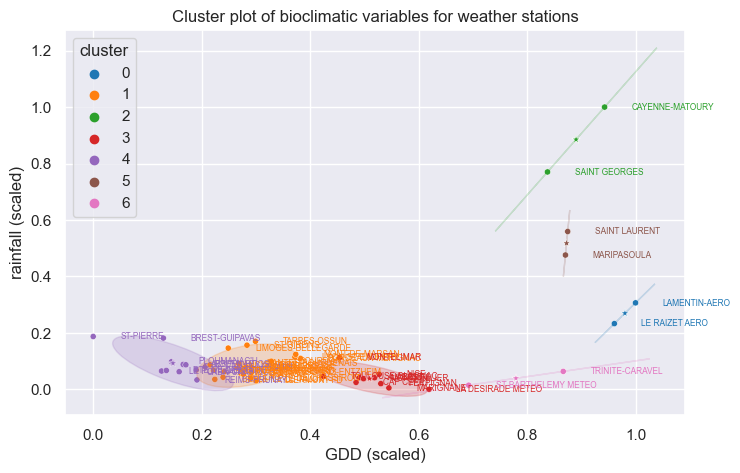

In [365]:
from matplotlib.patches import Ellipse

plt.figure(figsize=(8, 5))
sns.set_theme()

# define the color palette, it should be qualitative
# https://seaborn.pydata.org/tutorial/color_palettes.html
# Other palettes options are: 'muted', 'bright'
colors= sns.color_palette('tab10', k)

# Plot values
scatter = sns.scatterplot(x=GDD_rainfall_km.GDD,
                          y=GDD_rainfall_km.rainfall,
                          hue=GDD_rainfall_km.cluster,
                          palette=colors, s=20) #viridis , alpha=0.8

# Plot cluster centers
sns.scatterplot(x=km.cluster_centers_[:, 0],
                y=km.cluster_centers_[:, 1],
                color=colors,
                marker='*',
                s=40)


# Plot point labels
for i, label in enumerate(GDD_rainfall_km.index):
    scatter.text(GDD_rainfall_km.GDD.iloc[i] + 0.05,
                 GDD_rainfall_km.rainfall.iloc[i],
                 label,
                 fontsize=6,
                 color=colors [GDD_rainfall_km.cluster.iloc[i] ],
                 ha='left', va='center')

# Plot cluster ellipses
def calculate_cluster_eliipse(cluster_points):

    width_i, height_i, theta_i =  (0.0, 0.0, 0.0)

    if cluster_points.shape[0] > 1:

      # Compute the covariance matrix of cluster i
      cov_i = np.cov(cluster_i.T)

      # Compute the eigenvalues and eigenvectors of the covariance matrix
      eigvals_i, eigvecs_i = np.linalg.eig(cov_i)

      # Compute the angle of rotation of the ellipse
      theta_i = np.degrees(np.arctan2(*eigvecs_i[:, 0][::-1]))

      # Compute the width and height of the ellipse
      width_i, height_i = 4 * np.sqrt(np.abs(eigvals_i))

    return  width_i, height_i, theta_i

for i in range(k):
    # Get the points belonging to cluster i
    cluster_i = GDD_rainfall_km.loc[GDD_rainfall_km.cluster == i, ['GDD', 'rainfall']]

    width_i, height_i, theta_i = calculate_cluster_eliipse(cluster_i)

    # Plot the ellipse
    ellipse_i =  Ellipse(xy=km.cluster_centers_[i],
                           width=width_i,
                           height=height_i,
                           angle=theta_i,
                           alpha=0.2,
                           color=colors[i])

    plt.gca().add_patch(ellipse_i)

plt.title('Cluster plot of bioclimatic variables for weather stations')
plt.legend(title='cluster', loc='upper left')
plt.ylabel('rainfall (scaled)')
plt.xlabel('GDD (scaled)')
plt.show()

### Compare clustering and Winkler index classes
Let's see if the Winkler regions and clusters are aligned by plotting a bar plot where the bars correspond to each cluster, the height of the bar represents the number of stations in the cluster, and the color represents the Winkler index of counted stations.

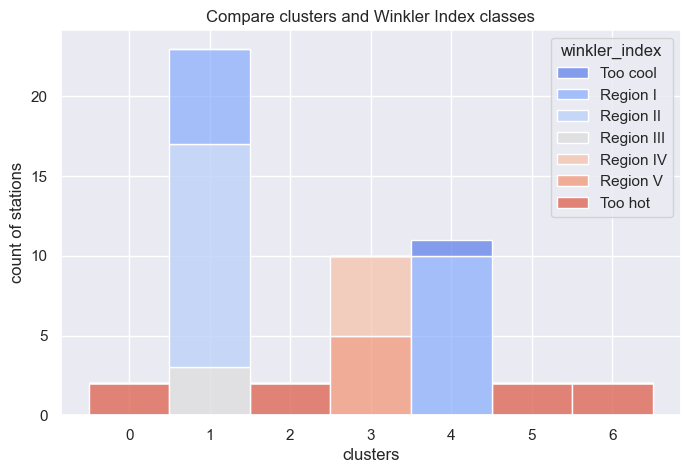

In [366]:
plt.figure(figsize=(8, 5))
sns.set_theme()

sns.histplot(x= km.labels_,
            hue=station_geo_agro_df_avg.winkler_index,
            stat='count',
            discrete=True,
            palette='coolwarm',
            multiple='stack')

plt.title('Compare clusters and Winkler Index classes')
plt.xlabel('clusters')
plt.ylabel('count of stations')
print()

OBSERVATIONS AND CONCLUSIONS

---

Although there is no exact match between the K-mean clusters and Winkler Index we still see that the "too hot" regions are separated from the rest in clusters 0,2, 5, and 6.


### Visualize regions sets based on clusters
Let's put the regions of the stations from the cluster "wine producing areas" in one set and the regions of other stations in another. We can plot the sets on Venn diagram and see how they intersect.

In [356]:
interesting_clusters = [1,3]

wine_regions  = set(station_geo_agro_df_avg.loc[GDD_rainfall_km.cluster.isin(interesting_clusters) , 'region'])
cider_regions = set(station_geo_agro_df_avg.loc[GDD_rainfall_km.cluster.isin(interesting_clusters) == False, 'region'])

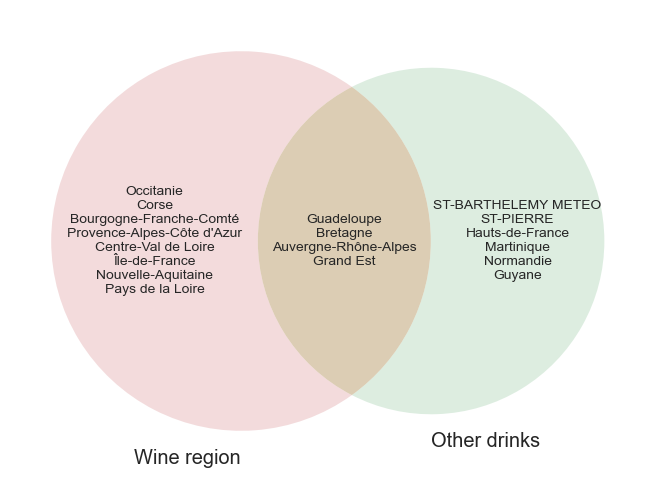

In [367]:
from matplotlib_venn import venn2
plt.figure(figsize=(10, 6))
sns.set_theme()

# Create a Venn diagram with custom labels
venn_diagram  = venn2( [wine_regions , cider_regions],
                        set_labels = ('Wine region', 'Other drinks'))

only_wine = '\n'.join(wine_regions.difference(cider_regions))
venn_diagram.get_label_by_id('10').set_text( only_wine )
venn_diagram.get_label_by_id('10').set_fontsize(10)

venn_diagram.get_patch_by_id('10').set_alpha(0.2)

only_cider = '\n'.join(cider_regions.difference(wine_regions))
venn_diagram.get_label_by_id('01').set_text( only_cider )
venn_diagram.get_label_by_id('01').set_fontsize(10)

venn_diagram.get_patch_by_id('01').set_alpha(0.2)

wine_and_cider = '\n'.join(cider_regions.intersection(wine_regions))
venn_diagram.get_label_by_id('11').set_text( wine_and_cider )
venn_diagram.get_label_by_id('11').set_fontsize(10)

venn_diagram.get_patch_by_id('11').set_alpha(0.6)
# Display the plot
plt.show()

OBSERVATONS AND CONCLUSIONS:


---



- the separation of the regions is very close to real-life
- regions, where wine grapevines grow everywhere are identified e.g. Burgundy or Loire Valley
- regions with too hot and too cold weather e.g Martinique or Normandie
- and all the others are in between


### Principal Component Analysis
Principal Component Analysis (PCA) is a useful technique for exploratory data analysis, allowing you to better visualize the variation present in a dataset with many variables.

The first principal component (PC1) explains the most variance in the data, the second principal component (PC2) explains the second most variance, and so on. The loading of the eigenvector represents how important each original variable is to the component.

We can combine agroclimatic and geospatial variables of wine growing regions and analyze if there is any correlation between them.

In [368]:
from sklearn.decomposition import PCA

GDD_rainfall_pca = station_geo_agro_df.select_dtypes(include={'float64'})

scaler = StandardScaler(copy=False).set_output(transform='pandas')
scaler.fit_transform(GDD_rainfall_pca)

pca = PCA()
_ = pca.fit_transform(GDD_rainfall_pca)

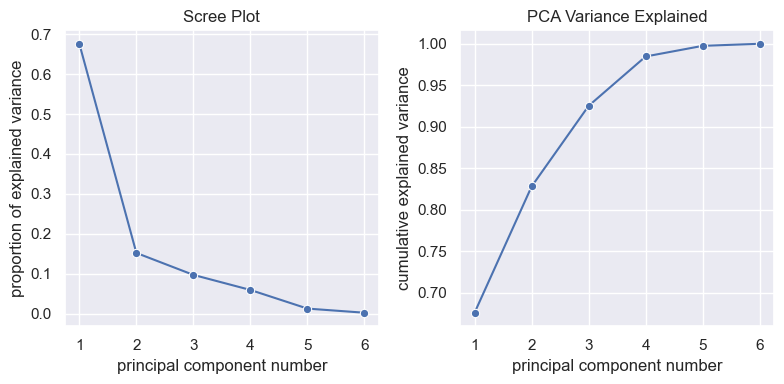

In [369]:
# Scree plot
plt.figure(figsize=(8, 4))
sns.set_theme()
#sns.set_theme(context='notebook', style='darkgrid', palette='deep',
#              font='sans-serif', font_scale=1, color_codes=True, rc=None)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(explained_variance_ratio) + 1),
             y=explained_variance_ratio,
             marker='o')

plt.title('Scree Plot')
plt.xlabel('principal component number')
plt.ylabel('proportion of explained variance')

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(explained_variance_ratio) + 1),
             y=cumulative_variance,
             marker='o')

plt.title('PCA Variance Explained')
plt.xlabel('principal component number')
plt.ylabel('cumulative explained variance')


plt.tight_layout()
plt.show()


OBSERVATIONS:


---

- from the plots above we can see that using 2 PCA components explains over 80% of data variance. So instead of using 3 geo loaction variables and 3 agroclimatic variables in classification we can just use 2 PCA components.


With only 2 components we can visualize the data on a 2D plot to observe the possible clustering tendencies of multiple predictors.


In [370]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(GDD_rainfall_pca)

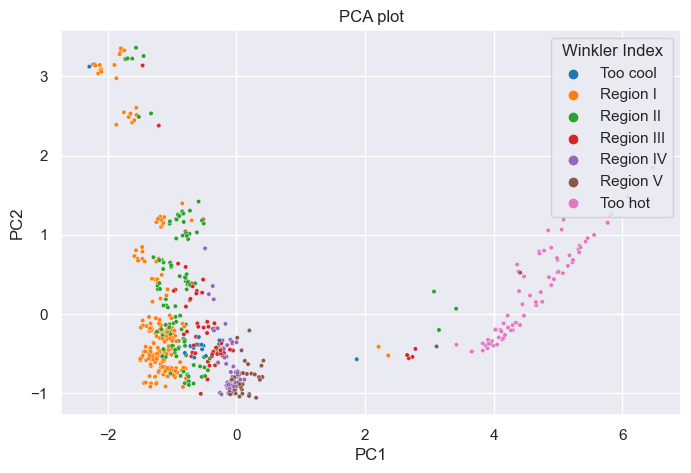

In [371]:
plt.figure(figsize=(8, 5))

sns.scatterplot(x=pca_result[:, 0],
                y=pca_result[:, 1],
                hue= station_geo_agro_df.winkler_index, #'winkler_index',
                palette='tab10',
                s=10)

# Set labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot')
plt.legend(title='Winkler Index', loc='upper right')


plt.show()

OBSERVATIONS:


---

- on this plot it looks like the PCA components are clustered in a slight resemblance of the Winkler Index categories  



## Supervised classification

For the supervised classification, we will label the weather stations with:

- binary "yes" and "no" for wine production
- prevalent white wine grape varieties (fr: *cepage*)
- prevalent red wine grape varieties

In [372]:
query_station_geo_agro_cepage = '''
PREFIX wes: <http://ns.inria.fr/meteo/weatherstation/>
PREFIX vin: <http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#>


SELECT ?region ?station ?stationName
       ?lat ?long ?alt
       ?year ?GDD ?GST ?rainfall
       ?WhiteWine ?RedWine

WHERE {

   ?station rdfs:label ?stationName;
            geo:lat ?lat;
            geo:long ?long;
            geo:altitude ?alt.

   OPTIONAL{ ?station dct:Location ?region }

   OPTIONAL {
   ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                        wevp-agro:growingDegreeDay ?GDD;
                                        wevp-agro:growingSeasonAvgTemperature ?GST
                                     ] .
    }
   OPTIONAL {
    ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                         wevp-agro:yearlyRainfall ?rainfall
                                     ] .
   }

   OPTIONAL {
    ?RedWine vin:locatedIn ?station;
                vin:madeIntoWine vin:RedWine.
   }

   OPTIONAL {
    ?WhiteWine vin:locatedIn ?station;
                vin:madeIntoWine vin:WhiteWine.
   }


}
#GROUP BY ?stationName ?year
ORDER BY ?stationName ?year

'''
station_geo_agro_cepage_df = sparqlQuery(graph, prefixes=sparql_prefix, query=query_station_geo_agro_cepage)

station_geo_agro_cepage_df.shape

(559, 12)

In [373]:
# Substitute namespaces with prefixes
station_geo_agro_cepage_df = applyPrefixes(station_geo_agro_cepage_df, parsePrefixes(query_station_geo_agro_cepage))

# fill n/a
station_geo_agro_cepage_df.rainfall.fillna( station_geo_agro_df.groupby('stationName').rainfall.transform('mean'), inplace=True)

# descretise GDD into Winkler Index
station_geo_agro_cepage_df['winkler_index'] = winkler_discretizer.fit_transform(station_geo_agro_cepage_df.GDD)


In [ ]:
describe_dataframe(station_geo_agro_cepage_df)

### Logistic Regression

Let's see if we can predict from the geospatial and bioclimatic variables if an area around a weather station can grow grapevines or not.

We can split the data on the train and test sets randomly or we can try to predict the last year's outcome based on the previous years. We chose the latter.  

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

last_year = station_geo_agro_cepage_df.year.max()

X_train = station_geo_agro_cepage_df.loc[station_geo_agro_cepage_df.year < last_year].select_dtypes("float64")
y_train = station_geo_agro_cepage_df.loc[station_geo_agro_cepage_df.year < last_year , ['WhiteWine', 'RedWine']].notna().all(axis=1)

X_test = station_geo_agro_cepage_df.loc[station_geo_agro_cepage_df.year == last_year].select_dtypes("float64")
y_test = station_geo_agro_cepage_df.loc[station_geo_agro_cepage_df.year == last_year , ['WhiteWine', 'RedWine']].notna().all(axis=1)

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

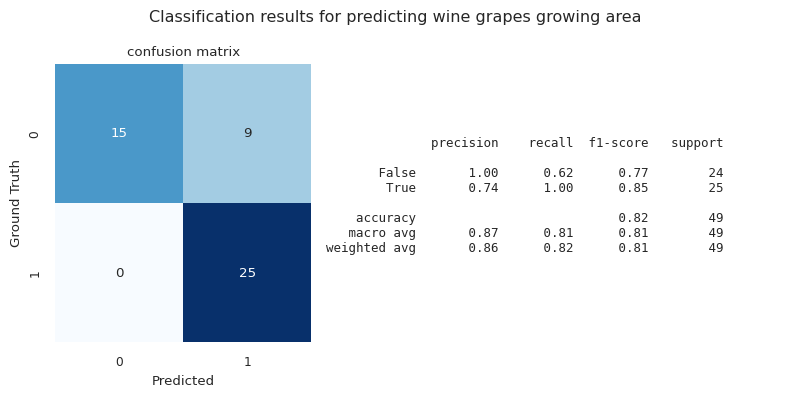

In [44]:
# Display results using seaborn heatmap

plt.figure(figsize=(8, 4))
sns.set_theme(font_scale=0.8)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

plt.subplot(1,2,1)
sns.heatmap(conf_matrix, annot=True,
            fmt='d', cmap='Blues', cbar=False )

plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.grid(None)

plt.subplot(1,2,2)
plt.text(0.0, 0.5, classification_rep, ha='center', va='center',
         fontsize=9, fontdict={'family': 'monospace'})
plt.axis('off')

plt.suptitle('Classification results for predicting wine grapes growing area')
plt.tight_layout()
plt.show()

OBSERVATIONS AND CONCLUSIONS

---


- Indeed the agroclimatic and geospatial parameters define the wine production potential of the area pretty well.

### Multinomial logistic regression / Multi-class Classifier

Let's consider the more difficult task of predicting the Winkler Index of an area around weather stations with multiple predictors.

In [45]:
from sklearn.preprocessing import StandardScaler

X = station_geo_agro_cepage_df.select_dtypes('float64')
y = station_geo_agro_cepage_df.winkler_index

X_train = X.loc[station_geo_agro_cepage_df.year < last_year]
y_train = y.loc[station_geo_agro_cepage_df.year < last_year]

X_test = X.loc[station_geo_agro_cepage_df.year == last_year]
y_test = y.loc[station_geo_agro_cepage_df.year == last_year]

scaler = StandardScaler().fit(X)
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

In [46]:
from sklearn.model_selection import GridSearchCV

lr_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Define hyperparameter grid for tuning
param_grid = {'C': [0.001, 0.1, 0.5, 1.0]}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(lr_multi, param_grid, cv=5)
grid_search.fit(X_train_s, y_train)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_s)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Best Hyperparameters:", grid_search.best_params_)

Accuracy: 0.40816326530612246
Best Hyperparameters: {'C': 1.0}


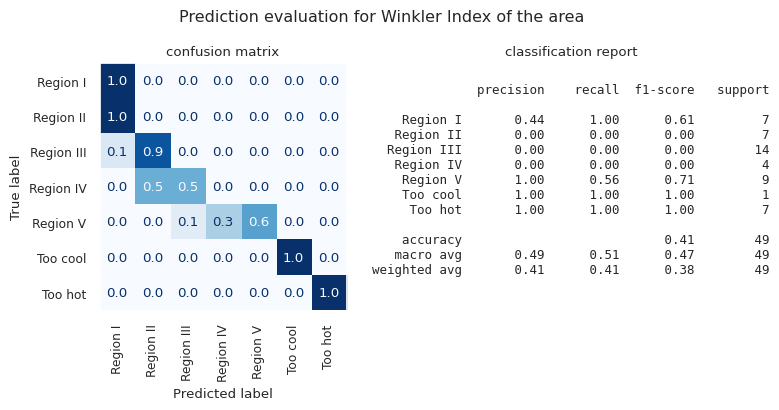

In [47]:
# Display results using ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

classification_rep = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 4))
sns.set_theme(font_scale=0.8)

ax_left = plt.subplot(1,2,1)
ax_left.set_title('confusion matrix')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                       labels= best_model.classes_,
                                       cmap='Blues',
                                       normalize= 'true',
                                       colorbar=False,
                                       values_format='.1f',
                                       xticks_rotation='vertical',
                                       ax=ax_left)
plt.grid(None)
axis_right= plt.subplot(1,2,2)
axis_right.set_title('classification report')
plt.text(0.5, 0.5, classification_rep, ha='center', va='center',
         fontsize=9, fontdict={'family': 'monospace'})
plt.axis('off')

plt.suptitle('Prediction evaluation for Winkler Index of the area')

plt.tight_layout()
plt.show()

OBSERVATONS AND CONCLUSIONS

---

- the multinomial logistic regression did not give us spectacular results with ~41% accuracy
- at least the confusion was primarily between adjacent classes

### Decision tree

Now we want to train a model that based on geographical coordinates and geo-climatic variables predicts what kind of red grape variety is grown in the area.

We need to take data preprocessing preprocessing steps:

- take only the numeric predictor variables
- encode the target variable RedWine
- set aside the last year for testing

We'll start with  red wines and the default parameters of the Decision Tree classifier.

In [374]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

X = station_geo_agro_cepage_df.select_dtypes('float64')
y_red = station_geo_agro_cepage_df.RedWine.to_frame()
y_white = station_geo_agro_cepage_df.WhiteWine.to_frame()

y =  y_red

X_train = X.loc[station_geo_agro_cepage_df.year < last_year]
y_train = y.loc[station_geo_agro_cepage_df.year < last_year]

X_test = X.loc[station_geo_agro_cepage_df.year == last_year]
y_test = y.loc[station_geo_agro_cepage_df.year == last_year]

# define the preprocessing pipeline for the target variable WhiteWine
preproc_y = make_pipeline( SimpleImputer(missing_values=pd.NA,
                                        strategy='constant',
                                        fill_value='raisins'),
                         OrdinalEncoder(dtype='int'))


y_train = preproc_y.fit_transform(y_train).ravel()
y_test = preproc_y.fit_transform(y_test).ravel()

##### Using default hyperparameters

In [375]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

# Create a decision tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the decision tree model on the training data
decision_tree.fit(X_train, y_train)

display(decision_tree)
print(pd.DataFrame([decision_tree.feature_importances_.round(2)],
                   columns=decision_tree.feature_names_in_,
                   index=['feature importance']))


y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Max depth:", decision_tree.get_depth())
print('Max leaves:', decision_tree.get_n_leaves())

# Print the decision tree rules
tree_rules = export_text(decision_tree,
                         feature_names=list(decision_tree.feature_names_in_))
print("Decision Tree Rules:")
print(tree_rules)

DecisionTreeClassifier(random_state=42)

                     lat  long   GDD  GST  rainfall
feature importance  0.53   0.4  0.08  0.0       0.0
Accuracy: 0.9387755102040817
Max depth: 7
Max leaves: 19
Decision Tree Rules:
|--- long <= -1.67
|   |--- class: 0
|--- long >  -1.67
|   |--- lat <= 44.66
|   |   |--- long <= 4.97
|   |   |   |--- GDD <= 1832.50
|   |   |   |   |--- GDD <= 1764.25
|   |   |   |   |   |--- class: 7
|   |   |   |   |--- GDD >  1764.25
|   |   |   |   |   |--- long <= 0.44
|   |   |   |   |   |   |--- class: 7
|   |   |   |   |   |--- long >  0.44
|   |   |   |   |   |   |--- class: 3
|   |   |   |--- GDD >  1832.50
|   |   |   |   |--- lat <= 43.60
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- lat >  43.60
|   |   |   |   |   |--- long <= 0.44
|   |   |   |   |   |   |--- class: 7
|   |   |   |   |   |--- long >  0.44
|   |   |   |   |   |   |--- class: 3
|   |   |--- long >  4.97
|   |   |   |--- lat <= 43.26
|   |   |   |   |--- class: 0
|   |   |   |--- lat >  43.26
|   |   |   |   |--- c

OBSERVATIONS


---
- the decision tree model has way too many (19) leaf nodes and the rules are very complicated, while we have only 8 categories of Red Grapes.
- it looks like it is not the best model and we should try to find a better set of hyperparameters

##### Grid Search with cross-validation

In [376]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': list(range(2,10)),
              'max_leaf_nodes': list(range(3,10))}

# Use GridSearchCV for hyperparameter tuning
decision_tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, verbose=0,
                           scoring='accuracy')
grid_search.fit(X_train.drop(columns='GDD'), y_train)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test.drop(columns='GDD'))

display(best_model)

print(pd.DataFrame([best_model.feature_importances_.round(2)],
                   columns=best_model.feature_names_in_,
                   index=['feature importance']))

print('accuracy:', accuracy_score(y_test, y_pred))

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9, random_state=42)

                     lat  long  GST  rainfall
feature importance  0.42  0.48  0.1       0.0
accuracy: 0.7959183673469388


##### Plot the decision tree

`scikit-learn` provides two ways to display a decision tree
- `plot_tree` - quicker method
- `export_graphviz` - renders better results

Click on the image to enlarge it


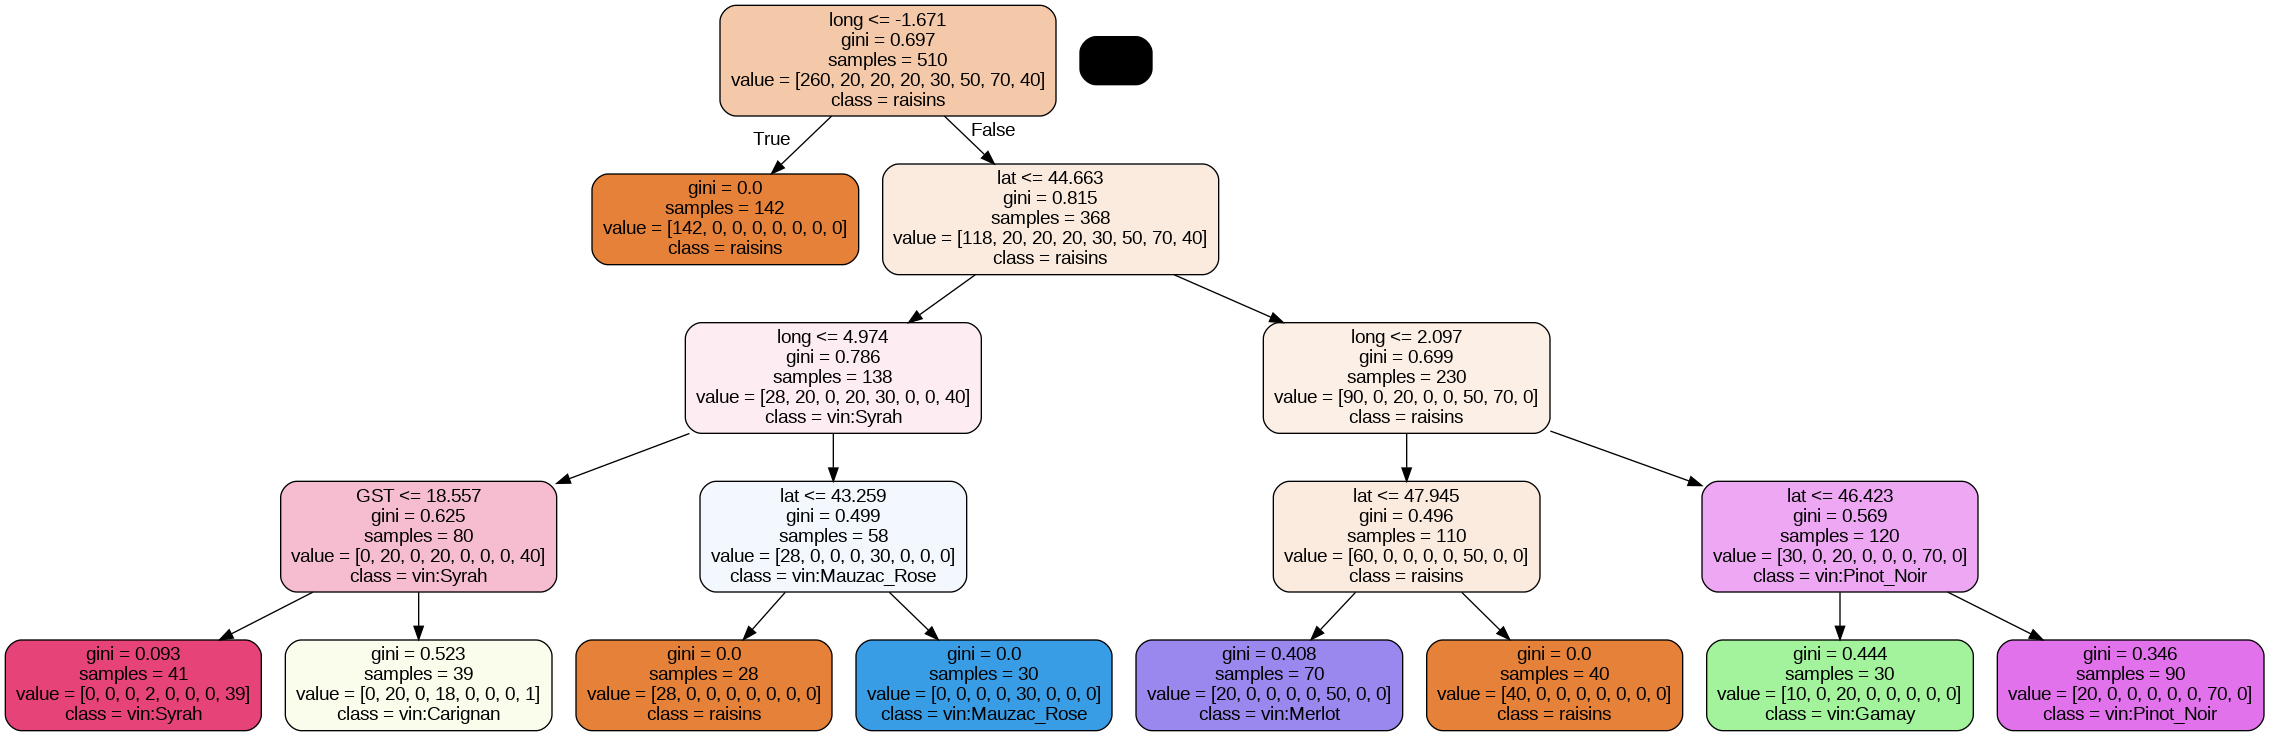

<Figure size 1000x500 with 0 Axes>

In [51]:
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display, Image

plt.figure(figsize=(10, 5))

plot_tree = False

if plot_tree:
    plot_tree(best_model,
              feature_names=list(best_model.feature_names_in_),
              class_names=list(preproc_y[-1].categories_[0]),
              label='all',
              filled=True,  rounded=True,
              impurity=False, proportion = False,
              fontsize =8,
              precision=2 )

    plt.show()
else:
    dot_data = export_graphviz(best_model, out_file=None,
                              feature_names=list(best_model.feature_names_in_),
                              class_names=list(preproc_y[-1].categories_[0]),
                              filled = True,
                              rounded= True)

    # Draw graph
    im = pydotplus.graph_from_dot_data(dot_data)

    # Show graph
    print('Click on the image to enlarge it')
    display(Image(im.create_png()))

OBSERVATIONS AND CONCLUSIONS


---

- within a constraint of not more than 10 leaf nodes the best Decision Tree model has 5 levels of splits and 9 leaf nodes for 8 categories
- this model is much simpler yet the accuracy is almost 80%
- The model splits the observation mostly on geographical variables

### Random Forest

We will train a Random Forest model to predict the white wine grape variety depending on geographical coordinates and geo-climatic variables

In [377]:
y = y_white

y_train = y.loc[station_geo_agro_cepage_df.year < last_year]
y_test = y.loc[station_geo_agro_cepage_df.year == last_year]

y_train = preproc_y.fit_transform(y_train).ravel()
y_test = preproc_y.fit_transform(y_test).ravel()

In [378]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Create a decision tree model
random_forest = RandomForestClassifier(random_state=42)

# Fit the decision tree model on the training data
random_forest.fit(X_train, y_train)

# Optionally, you can print the decision tree rules
#tree_rules = export_text(decision_tree, feature_names=list(decision_tree.feature_names_in_))
#print("Decision Tree Rules:")
#print(tree_rules)

display(random_forest)

print(pd.DataFrame([random_forest.feature_importances_.round(2)],
                   columns=random_forest.feature_names_in_,
                   index=['feature importance:']))

print('accuracy:' , random_forest.score(X_test, y_test) )


RandomForestClassifier(random_state=42)

                      lat  long   GDD   GST  rainfall
feature importance:  0.32  0.39  0.12  0.13      0.05
accuracy: 0.9183673469387755


OBSERVATIONS AND CONCLUSIONS


---
- the accuracy of the Random Forest model is pretty high at ~92%
- the model determined that the most important feature is longitude, but of course because we only considered metropolitan France when we compiled the grapevine mini dataset
- the model's second most important feature is latitude - we can intuitively confirm that too
- GDD & GST have the same importance as their meaning is pretty close
- rainfall is not a very significant factor for the variety of the wine grapes

It is not very practical to visualize a tree from the _random forest_ model but for demonstration purposes, we visualize the first estimator from the model.

The `sklearn.tree.plot_tree` function does not allow to choose leaf colors (at least we could not find the way to do it). Below we try another visualization way using `dtreeviz` package.

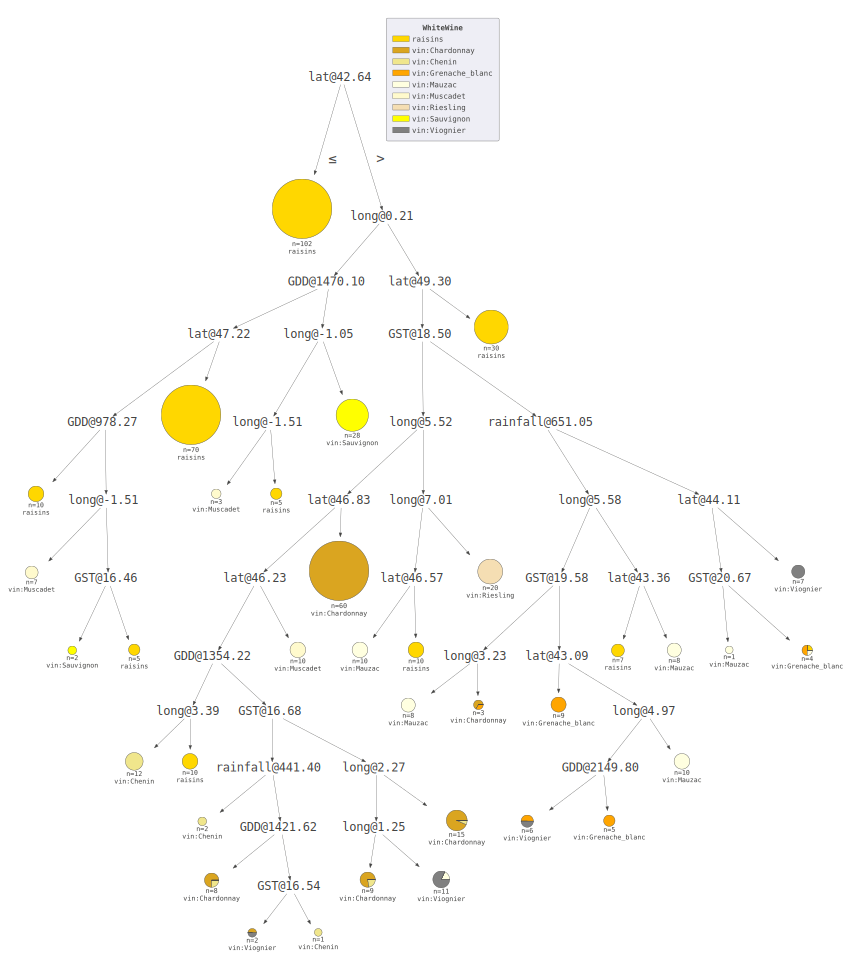

<Figure size 800x500 with 0 Axes>

In [379]:
import dtreeviz
plt.figure(figsize=(8,5))

# Visualize the decision tree using dtreeviz
viz = dtreeviz.model(random_forest.estimators_[0],
                    X_train=X_train,
                    y_train=y_train,
                    target_name='WhiteWine',
                    feature_names=random_forest.feature_names_in_,
                    class_names=list(preproc_y[-1].categories_[0]))

# Make up the color scheme for the classses
# In dtreeviz the color map has to be the the n-th element of a list,
# where n is the number of classes.
blanc_colors = ['gold', 'goldenrod',  'khaki', 'orange',
                'lightyellow',  'lemonchiffon',
                'wheat', 'yellow','gray', 'palegreen',  'navajowhite' ]

my_colors = [None] *  random_forest.n_classes_ + [blanc_colors]

viz.view(fancy=False,
         leaftype='pie',
         fontname="monospace",
         scale=1.0,
         colors={'classes': my_colors},
         )

This notebook just scratched the surface of the capabilities that integration of knowledge graphs and machine learning can present. However, it can serve as a starting point for a project that
- explores a knowledge graph dataset
- looks for a suitable ML classification model
- fine-tunes hyperparameters of selected model
- visualizes the quality metrics and results